In [38]:
import numpy as np

# データの読み込み
file_path = 'processed_data/all_data_combined.npz'
data = np.load(file_path, allow_pickle=True)

# 保存されているデータのキーを確認
print("Keys:", data.files)

# カラム名を表示（何番目が何のデータか確認するため）
cols = data['columns']
print(f"\n--- Column Names (Total: {len(cols)}) ---")
for i, col in enumerate(cols):
    print(f"{i}: {col}")

# データの形状確認
ensemble = data['ensemble']
subject_ids = data['subject_ids']

print("\nEnsemble Shape:", ensemble.shape)     # (サンプル数, 時間, 特徴量)
print("Subject IDs Shape:", subject_ids.shape) # (サンプル数,)

Keys: ['ensemble', 'subject_ids', 'columns', 'id_map']

--- Column Names (Total: 26) ---
0: Pressure_1
1: Pressure_2
2: Pressure_3
3: Pressure_4
4: Pressure_5
5: Pressure_6
6: Pressure_7
7: Pressure_8
8: Accel_X
9: Accel_Y
10: Accel_Z
11: Gyro_X
12: Gyro_Y
13: Gyro_Z
14: Hip_XY
15: Hip_YZ
16: Hip_ZX
17: Knee_XY
18: Knee_YZ
19: Knee_ZX
20: Ankle_XY
21: Ankle_YZ
22: Ankle_ZX
23: Fx
24: Fy
25: Fz

Ensemble Shape: (13545, 200, 26)
Subject IDs Shape: (13545,)


In [39]:
import numpy as np

# 1. 入力(X)と正解(y)の切り出し（前回と同じ）
X_all = ensemble[:, :, :23]
y_all = ensemble[:, :, 23:]

# 2. 被験者IDごとの分割設定
# 全被験者のIDリストを取得
unique_subjects = np.unique(subject_ids)
print(f"全被験者ID: {unique_subjects}")

# --- ここで分割するIDを指定します ---
# 例: ID 10, 11 をテスト(完全未知)にする
test_sub_ids = [10, 11] 
# 例: ID 8, 9 を検証用(学習中に精度を見るための未知データ)にする
val_sub_ids  = [8, 9]   
# 残りを学習用にする
train_sub_ids = [0, 1, 2, 3, 4, 5, 6, 7]

print(f"\n--- Split Config ---")
print(f"Train IDs: {train_sub_ids}")
print(f"Val   IDs: {val_sub_ids}")
print(f"Test  IDs: {test_sub_ids}")

# 3. マスク作成とデータの抽出
# np.isin を使って、該当するIDのデータ位置(True/False)を取得します
train_mask = np.isin(subject_ids, train_sub_ids)
val_mask   = np.isin(subject_ids, val_sub_ids)
test_mask  = np.isin(subject_ids, test_sub_ids)

# データ分割実行
X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val,   y_val   = X_all[val_mask],   y_all[val_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

print(f"\n--- Data Split Completed (Subject-wise) ---")
print(f"Train : X={X_train.shape}, y={y_train.shape}")
print(f"Val   : X={X_val.shape},   y={y_val.shape}")
print(f"Test  : X={X_test.shape},  y={y_test.shape}")

# 確認: データ混入がないかチェック
train_ids_check = np.unique(subject_ids[train_mask])
test_ids_check = np.unique(subject_ids[test_mask])
intersect = np.intersect1d(train_ids_check, test_ids_check)
if len(intersect) == 0:
    print("OK: 学習データとテストデータに重複する被験者はいません。")
else:
    print(f"WARNING: データ混入があります -> {intersect}")

全被験者ID: [ 0  1  2  3  4  5  6  7  8  9 10 11]

--- Split Config ---
Train IDs: [0, 1, 2, 3, 4, 5, 6, 7]
Val   IDs: [8, 9]
Test  IDs: [10, 11]

--- Data Split Completed (Subject-wise) ---
Train : X=(8672, 200, 23), y=(8672, 200, 3)
Val   : X=(2292, 200, 23),   y=(2292, 200, 3)
Test  : X=(2581, 200, 23),  y=(2581, 200, 3)
OK: 学習データとテストデータに重複する被験者はいません。


In [40]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# ---  Tensor化とDataLoaderの作成 ---

BATCH_SIZE = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tensorへの変換関数 (float32にキャスト)
def to_tensor(arr):
    return torch.tensor(arr, dtype=torch.float32)

# Numpy配列を直接Tensorに変換
X_train_tensor = to_tensor(X_train)
y_train_tensor = to_tensor(y_train)

X_val_tensor   = to_tensor(X_val)
y_val_tensor   = to_tensor(y_val)

X_test_tensor  = to_tensor(X_test)
y_test_tensor  = to_tensor(y_test)

# Datasetの作成
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor,   y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

# DataLoaderの作成
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\n--- DataLoader Ready ---")
print(f"Train batches: {len(train_loader)}")
print(f"Val   batches: {len(val_loader)}")
print(f"Test  batches: {len(test_loader)}")
print(f"Using device: {device}")


--- DataLoader Ready ---
Train batches: 17
Val   batches: 5
Test  batches: 6
Using device: cuda


--- Current Configuration ---
input_dim: 23
output_dim: 3
hidden_dim: 512
num_layers: 4
dropout: 0.3
batch_size: 512
epochs: 200
lr: 0.001
weight_factor: 10.0
patience: 20
factor: 0.5
device: cuda
-----------------------------

Training Start...


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/200] Train: 1.89860 | Val: 0.20320 | LR: 0.001000
Epoch [2/200] Train: 0.25422 | Val: 0.11863 | LR: 0.001000
Epoch [3/200] Train: 0.18148 | Val: 0.10193 | LR: 0.001000
Epoch [4/200] Train: 0.14333 | Val: 0.09139 | LR: 0.001000
Epoch [5/200] Train: 0.11922 | Val: 0.08733 | LR: 0.001000
Epoch [6/200] Train: 0.10150 | Val: 0.09123 | LR: 0.001000
Epoch [7/200] Train: 0.09248 | Val: 0.08383 | LR: 0.001000
Epoch [8/200] Train: 0.07326 | Val: 0.07570 | LR: 0.001000
Epoch [9/200] Train: 0.06348 | Val: 0.08182 | LR: 0.001000
Epoch [10/200] Train: 0.06070 | Val: 0.07282 | LR: 0.001000
Epoch [11/200] Train: 0.05495 | Val: 0.07274 | LR: 0.001000
Epoch [12/200] Train: 0.04907 | Val: 0.07064 | LR: 0.001000
Epoch [13/200] Train: 0.04629 | Val: 0.07048 | LR: 0.001000
Epoch [14/200] Train: 0.04657 | Val: 0.06965 | LR: 0.001000
Epoch [15/200] Train: 0.04242 | Val: 0.06906 | LR: 0.001000
Epoch [16/200] Train: 0.04057 | Val: 0.06649 | LR: 0.001000
Epoch [17/200] Train: 0.03958 | Val: 0.07578 | LR

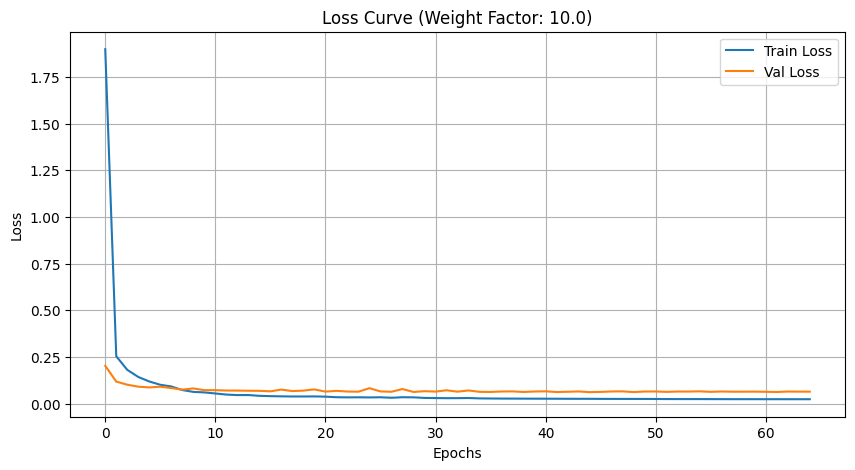

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import copy
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# ==========================================
# ★条件設定
# ==========================================
CONFIG = {
    # --- データ・モデル設定 ---
    'input_dim':  23,    # 入力特徴量数
    'output_dim': 3,     # 出力特徴量数 (Fx, Fy, Fz)
    'hidden_dim': 512,   # LSTMの隠れ層サイズ (A6000なら256~512でOK)
    'num_layers': 4,     # LSTMの層の深さ
    'dropout':    0.3,   # ドロップアウト率
    
    # --- 学習ハイパーパラメータ ---
    'batch_size': 512,   # バッチサイズ (GPUメモリに合わせて調整)
    'epochs':     200,   # 最大エポック数
    'lr':         0.001, # 初期学習率
    
    # --- Loss関数の重み (重要) ---
    # 5.0~10.0推奨。100.0はノイズを拾いすぎる可能性あり
    'weight_factor': 10.0, 
    
    # --- スケジューラ・Early Stopping ---
    'patience':   20,    # 何エポック改善なければ止めるか
    'factor':     0.5,   # 学習率を下げる倍率
    
    # --- システム設定 ---
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

print("--- Current Configuration ---")
for k, v in CONFIG.items():
    print(f"{k}: {v}")
print("-----------------------------")


# ==========================================
# 1. クラス定義 (Loss & Model)
# ==========================================
class WeightedMSELoss(nn.Module):
    def __init__(self, weight_factor=5.0, reduction='mean'):
        super(WeightedMSELoss, self).__init__()
        self.weight_factor = weight_factor
        self.reduction = reduction

    def forward(self, pred, target):
        mse = (pred - target) ** 2
        # 絶対値で重み付け (マイナスの力も考慮)
        weights = 1 + self.weight_factor * torch.abs(target)
        loss = weights * mse
        
        if self.reduction == 'mean':
            return torch.mean(loss)
        elif self.reduction == 'sum':
            return torch.sum(loss)
        else:
            return loss

class AdvancedBiLSTMRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob=0.3):
        super(AdvancedBiLSTMRegression, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=dropout_prob if num_layers > 1 else 0,
            bidirectional=True 
        )
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(128, output_dim)
        )
        
    def forward(self, x):
        r_out, _ = self.lstm(x)
        r_out = self.layer_norm(r_out)
        output = self.fc(r_out)
        return output

# ==========================================
# 2. セットアップ関数
# ==========================================
def setup_training(config):
    # モデル
    model = AdvancedBiLSTMRegression(
        input_dim=config['input_dim'],
        hidden_dim=config['hidden_dim'],
        num_layers=config['num_layers'],
        output_dim=config['output_dim'],
        dropout_prob=config['dropout']
    ).to(config['device'])
    
    # Loss関数 (Configからweight_factorを適用)
    criterion = WeightedMSELoss(weight_factor=config['weight_factor'])
    
    # オプティマイザ
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    
    # スケジューラ
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=config['factor'], patience=5, verbose=True
    )
    
    return model, criterion, optimizer, scheduler

# ==========================================
# 3. 実行処理
# ==========================================

# --- DataLoaderの準備 ---
# train_dataset, val_dataset は定義済みと仮定
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

# --- セットアップ ---
model, criterion, optimizer, scheduler = setup_training(CONFIG)

# --- 学習ループ ---
train_losses = []
val_losses = []
best_val_loss = float('inf')
early_stop_counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

print(f"\nTraining Start...")
start_time = time.time()

for epoch in range(CONFIG['epochs']):
    # Training
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(CONFIG['device']), targets.to(CONFIG['device'])
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(CONFIG['device']), targets.to(CONFIG['device'])
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    # Scheduler
    scheduler.step(epoch_val_loss)
    
    # Log
    if (epoch + 1) % 1 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{CONFIG['epochs']}] Train: {epoch_train_loss:.5f} | Val: {epoch_val_loss:.5f} | LR: {current_lr:.6f}")
    
    # Early Stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= CONFIG['patience']:
            print(f"Early stopping at epoch {epoch+1}")
            break

print(f"Training Finished. Time: {time.time() - start_time:.1f} sec")

# Load Best Model
model.load_state_dict(best_model_wts)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title(f"Loss Curve (Weight Factor: {CONFIG['weight_factor']})")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. テストデータでの推論実行
model.eval()
test_preds = []
test_targets = []

# 推論ループ
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        test_preds.append(outputs.cpu().numpy())
        test_targets.append(targets.cpu().numpy())

# (サンプル数, 200, 3) に結合
test_preds = np.concatenate(test_preds, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

print(f"Test Predictions Shape: {test_preds.shape}")

# --- 2. 詳細な評価指標の計算 (軸ごとに計算して表にする) ---
axis_names = ['Fx (Mediolateral)', 'Fy (Anterior-Posterior)', 'Fz (Vertical)']
metrics_data = []

for i, name in enumerate(axis_names):
    # Flattenして全時刻・全サンプルのデータを一列にする
    true_flat = test_targets[:, :, i].flatten()
    pred_flat = test_preds[:, :, i].flatten()
    
    # 基本指標
    mse = mean_squared_error(true_flat, pred_flat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_flat, pred_flat)
    r2 = r2_score(true_flat, pred_flat)
    corr = np.corrcoef(true_flat, pred_flat)[0, 1]
    
    # %RMSE (Normalized RMSE): レンジ(Max-Min)に対する誤差の割合[%]
    # 生体力学では力のスケールが違う軸を比較するのによく使います
    data_range = np.max(true_flat) - np.min(true_flat)
    n_rmse = (rmse / data_range) * 100 if data_range != 0 else 0.0
    
    metrics_data.append([name, rmse, n_rmse, mae, r2, corr])

# DataFrameで見やすく整形
df_metrics = pd.DataFrame(metrics_data, columns=['Axis', 'RMSE', '%RMSE', 'MAE', 'R2', 'Corr'])

print("\n--- Quantitative Evaluation (Quantitative) ---")
# 小数点以下を見やすくフォーマット表示
print(df_metrics.round(4).to_string(index=False))

# 全体平均の表示（論文のAbstractなどに書く用）
print("\n--- Overall Performance ---")
print(f"Mean %RMSE: {df_metrics['%RMSE'].mean():.2f}%")
print(f"Mean R2:    {df_metrics['R2'].mean():.4f}")

Test Predictions Shape: (2581, 200, 3)

--- Quantitative Evaluation (Quantitative) ---
                   Axis   RMSE   %RMSE    MAE     R2   Corr
      Fx (Mediolateral) 0.0341 13.5349 0.0254 0.2509 0.5564
Fy (Anterior-Posterior) 0.0874 12.7602 0.0560 0.1986 0.4492
          Fz (Vertical) 0.3092 17.5607 0.2108 0.5956 0.7779

--- Overall Performance ---
Mean %RMSE: 14.62%
Mean R2:    0.3484


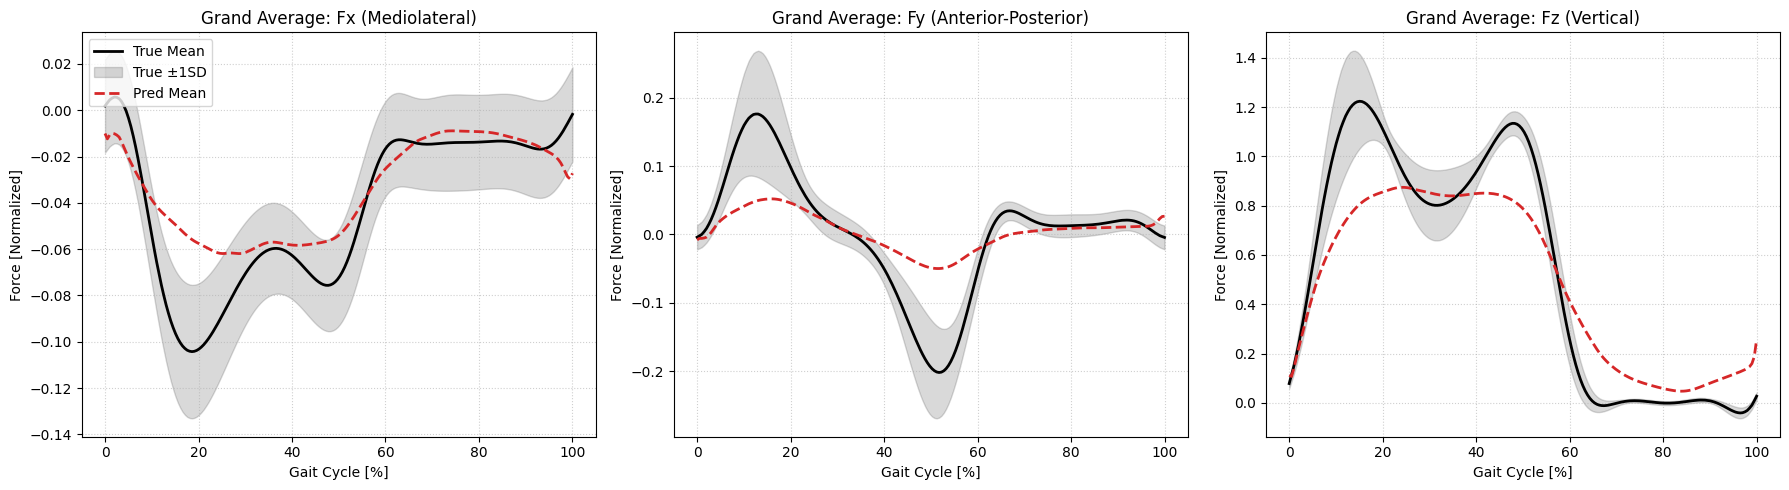

In [43]:
# 平均と標準偏差を計算 (axis=0: サンプル方向に計算)
mean_true = np.mean(test_targets, axis=0)
std_true  = np.std(test_targets, axis=0)

mean_pred = np.mean(test_preds, axis=0)
std_pred  = np.std(test_preds, axis=0)

# プロット作成
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axis_names = ['Fx (Mediolateral)', 'Fy (Anterior-Posterior)', 'Fz (Vertical)']

for i in range(3): # 各軸
    ax = axes[i]
    
    # 時間軸（0~100%に正規化して表示する場合のラベル）
    time_percent = np.linspace(0, 100, 200)
    
    # --- 実測値 (True) ---
    # 平均値を黒実線
    ax.plot(time_percent, mean_true[:, i], color='black', linewidth=2, label='True Mean')
    # ±1SDをグレーの帯で表示
    ax.fill_between(time_percent, 
                    mean_true[:, i] - std_true[:, i], 
                    mean_true[:, i] + std_true[:, i], 
                    color='black', alpha=0.15, label='True ±1SD')
    
    # --- 予測値 (Pred) ---
    # 平均値を赤破線
    ax.plot(time_percent, mean_pred[:, i], color='#d62728', linestyle='--', linewidth=2, label='Pred Mean')
    # 予測のSDも見たければ以下をコメントアウト解除（ごちゃごちゃするので描かないことも多い）
    # ax.fill_between(time_percent, 
    #                 mean_pred[:, i] - std_pred[:, i], 
    #                 mean_pred[:, i] + std_pred[:, i], 
    #                 color='red', alpha=0.1)

    ax.set_title(f"Grand Average: {axis_names[i]}")
    ax.set_xlabel("Gait Cycle [%]")
    ax.set_ylabel("Force [Normalized]")
    ax.grid(True, linestyle=':', alpha=0.6)
    
    if i == 0:
        ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

Plotting for Test Subjects: [10 11]


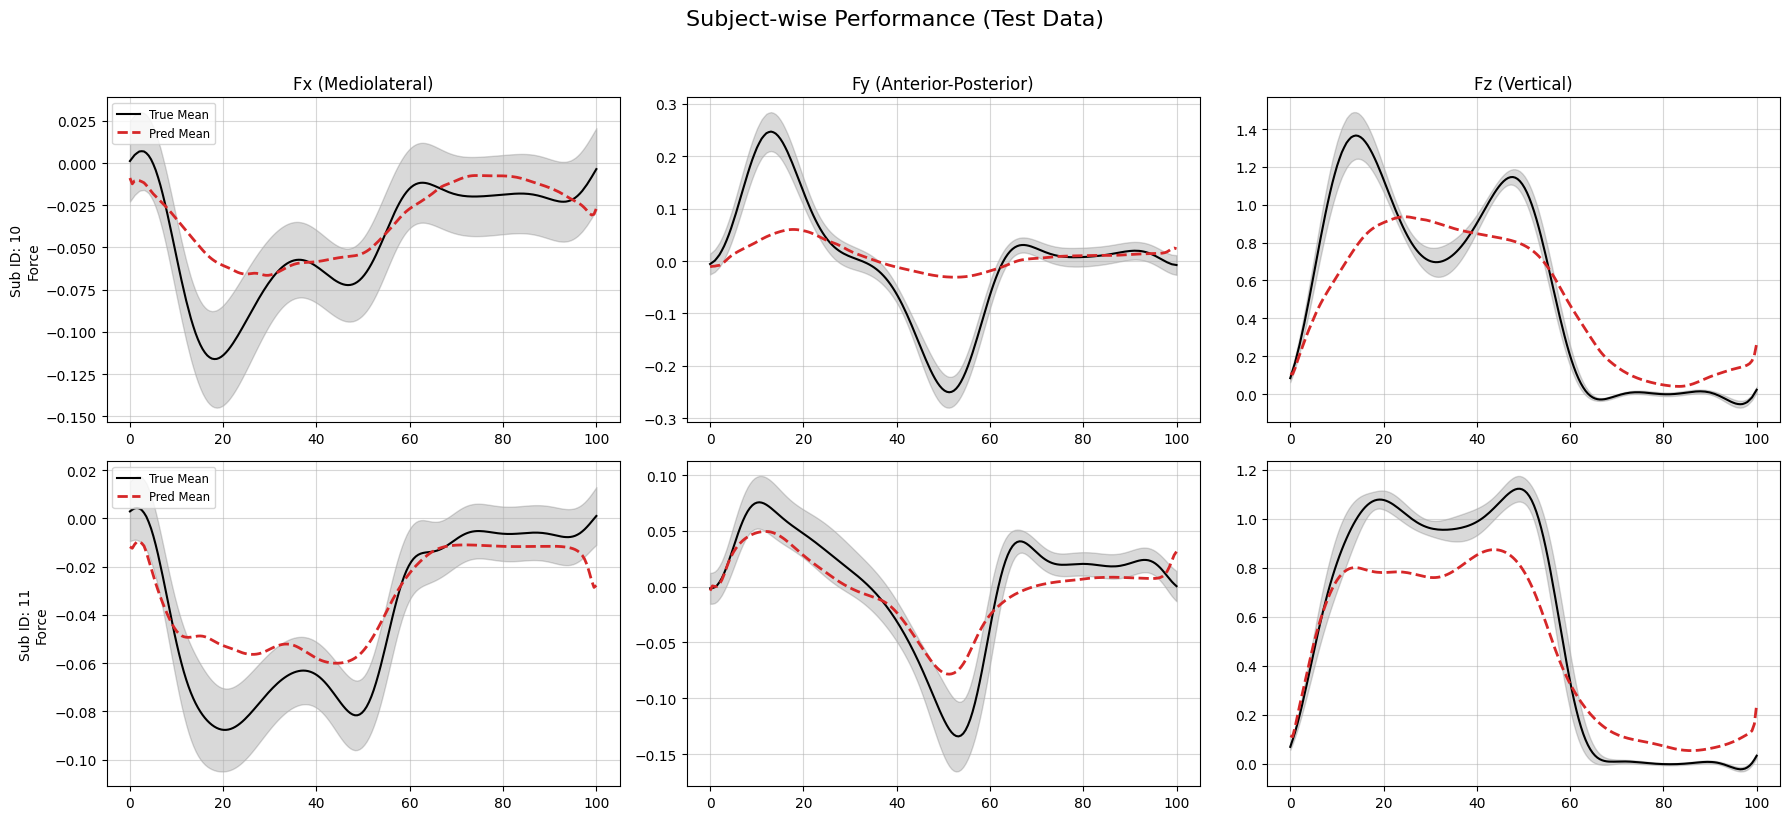

In [44]:
# テストデータに含まれるユニークなIDを取得
test_subject_ids = subject_ids[test_mask]
unique_test_subs = np.unique(test_subject_ids)
num_subs = len(unique_test_subs)

print(f"Plotting for Test Subjects: {unique_test_subs}")

fig, axes = plt.subplots(num_subs, 3, figsize=(18, 4 * num_subs))
# 被験者が1人の場合の処理（axesが1次元配列になるのを防ぐ）
if num_subs == 1: axes = np.expand_dims(axes, axis=0)

for row_idx, sub_id in enumerate(unique_test_subs):
    # その被験者のデータだけ抽出
    indices = np.where(test_subject_ids == sub_id)[0]
    
    sub_targets = test_targets[indices]
    sub_preds   = test_preds[indices]
    
    # その被験者の平均を計算
    sub_mean_true = np.mean(sub_targets, axis=0)
    sub_std_true  = np.std(sub_targets, axis=0)
    sub_mean_pred = np.mean(sub_preds, axis=0)
    
    # RMSEなどをタイトルに入れるとかっこいい
    sub_rmse = np.sqrt(mean_squared_error(sub_targets.reshape(-1,3), sub_preds.reshape(-1,3)))

    for col_idx in range(3):
        ax = axes[row_idx, col_idx]
        time_percent = np.linspace(0, 100, 200)

        # 実測値（平均 ± SD）
        ax.plot(time_percent, sub_mean_true[:, col_idx], color='black', label='True Mean')
        ax.fill_between(time_percent, 
                        sub_mean_true[:, col_idx] - sub_std_true[:, col_idx], 
                        sub_mean_true[:, col_idx] + sub_std_true[:, col_idx], 
                        color='black', alpha=0.15)
        
        # 予測値（平均のみ）
        ax.plot(time_percent, sub_mean_pred[:, col_idx], color='#d62728', linestyle='--', linewidth=2, label='Pred Mean')

        # レイアウト調整
        if col_idx == 0:
            ax.set_ylabel(f"Sub ID: {sub_id}\nForce")
            ax.legend(loc='upper left', fontsize='small')
        
        if row_idx == 0:
            ax.set_title(f"{axis_names[col_idx]}")
            
        ax.grid(True, alpha=0.5)

plt.suptitle(f"Subject-wise Performance (Test Data)", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()